## Data Fetching

In [ ]:
from mne_bids import (
    read_raw_bids,
    find_matching_paths,
    get_entity_vals,
)
import os
import numpy as np

def fetch_data(_subjects_data,_subjects_raw,_bids_number):
    #PATH to derivatives folder
    # bids_root = pathlib.Path('/home/kubano/Documents/diplomaWork/Data/ds004504/derivatives')
    base_folder = os.getcwd()
    files_loc = 'Data/ds004504/derivatives'
    # Full path of the subfolder
    main_folder_path = os.path.join(base_folder, files_loc)


    bids_root = main_folder_path


    sessions = get_entity_vals(bids_root, 'session', ignore_sessions='on') # Get available session values from the BIDS dataset
    datatype = 'eeg'
    extensions = [".set"]

    # Find BIDS paths for the EEG data matching the specified criteria
    bids_paths = find_matching_paths(bids_root, datatypes=datatype, sessions=sessions, extensions=extensions)

    for i in range(_bids_number):
      
        raw = read_raw_bids(bids_paths[i]) 
        #raw.plot(block=True, scalings='auto',show=False)
        subject_data = raw.info.get("subject_info") #IMPORTANT: you need to include participants.tsv file in the derivatives folder

        if (subject_data["Group"]=='A' or subject_data["Group"]=='C'):
            subject_data["record_duration"] = raw.times[-1] #Duration from last record
            subject_data['his_id'] = int(subject_data['his_id'][-3:]) #Add index for further classification
          
            _subjects_data.append(np.array(list(subject_data.values()))) #Convert dict to array
            _subjects_raw.append(raw.get_data())
            #print(raw.get_data())
        else:
            print(subject_data['his_id'])
        del subject_data
        del raw


subjects_data = []
subjects_raw = []
bids_number = 65

fetch_data(subjects_data,subjects_raw,bids_number)
subjects_data = np.vstack(subjects_data) #convert list to 2D

#Linux swap clear: sudo swapoff -a; sudo swapon -a
        

## Extract of features in time-frequency domain (STFT, CWT, Mel spectrum).

In [6]:
#STFT Functions ONLY
from scipy import signal
import matplotlib.pyplot as plt 
import pywt

def plot_spectro_data(eeg_data):
    fs = 500  # Sampling frequency in Hz
    window = 'hann'  # Window type
    nperseg = 400  # Window size
    noverlap = 2  # Overlap between windows
    fmin = 0  # Minimum frequency to plot
    fmax = 50  # Maximum frequency to plot

    frequencies, times, Sxx = signal.spectrogram(eeg_data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

    plt.pcolormesh(times, frequencies, 10*np.log10(Sxx)) # Apply log scaling for better visualization
    plt.title('EEG Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim(0, 50)
    plt.show()


def calc_spectro(eeg_data):
    fs = 500  # Sampling frequency in Hz
    window = 'hann'  # Window type
    nperseg = 512  # Window size
    noverlap = nperseg/2  # Overlap between windows
    fmin = 1  # Minimum frequency to plot
    fmax = 45  # Maximum frequency to plot

    frequencies, times, Sxx = signal.spectrogram(eeg_data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    return   frequencies, times, Sxx 


def plot_spectro(times, frequencies, Sxx,info):
    # plt.pcolormesh(times, frequencies, np.log10(Sxx), cmap='gray') # Apply log scaling for better visualization
    plt.pcolormesh(times, frequencies, -10*np.log10(Sxx),cmap='plasma') # Apply log scaling for better visualization
    array_string = np.array2string(info[:-1])
    plt.title(array_string)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power/Frequency (dB/Hz)', )
    plt.ylim(0, 45)
    plt.show()

def plot_save_spectro(times, frequencies, Sxx, channel,path):
    
    # plt.pcolormesh(times, frequencies, np.log10(Sxx), cmap='gray') # Apply log scaling for better visualization
    # plt.pcolormesh(times, frequencies, -10*np.log10(Sxx),cmap='plasma',vmin=80, vmax=220) # Apply log scaling for better visualization
    plt.pcolormesh(times, frequencies, -10*np.log10(Sxx),cmap='plasma',vmin=80, vmax=220) # Apply log scaling for better visualization
    label_str =  str(channel).zfill(2)
    image_path = os.path.join(path, label_str+".png")
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    # plt.title(label_str)
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (Hz)')
    # plt.colorbar(label='Power/Frequency (dB/Hz)', )
    plt.ylim(1, 45)
    plt.savefig(image_path,bbox_inches='tight')
    # plt.show()
    # print(image_path)
    


def signal_dev_to_epoch(subjects_raw_compose):

    fs = 500  # Sampling frequency in Hz
    epoch_length = 20  # Epoch length in seconds
    epoch_samples = epoch_length * fs  # Number of samples per epoch
    num_epochs = len(subjects_raw_compose) // epoch_samples
    frequencies, times, Sxx = calc_spectro(subjects_raw_compose[:epoch_samples])
    Sxx = Sxx * 0

    for epoch_index in range(num_epochs):
        start_sample = epoch_index * epoch_samples
        end_sample = start_sample + epoch_samples

            # Extract the EEG data for the current epoch
        epoch_data = subjects_raw_compose[start_sample:end_sample]
        _, _, Sxx_temp  = calc_spectro(epoch_data)
        Sxx = Sxx + Sxx_temp
        
    return  times, frequencies, Sxx
    


In [ ]:
#CWT

def make_cwt(signal):
    scales = np.arange(1, 45)  # Define the range of scales for the CWT
    cwt_result, frequencies = pywt.cwt(signal, scales, 'mexh')  # You can use different wavelets like 'morl', 'gaus1', etc.
    cwt_result_normalized = (np.abs(cwt_result) - np.min(np.abs(cwt_result))) / (np.max(np.abs(cwt_result)) - np.min(np.abs(cwt_result)))

    return cwt_result_normalized, frequencies

def plot_cwt(cwt_result,frequencies,len):
    
    plt.figure(figsize=(10, 6))
    # Plot the CWT
    plt.imshow(np.abs(cwt_result), extent=[0, len, 1, 45], aspect='auto', cmap='inferno')

    plt.title('Continuous Wavelet Transform (CWT)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.colorbar(label='Magnitude')
    plt.show()


In [ ]:
# Mel spectrum

import librosa
import librosa.display
def plot_mel(eeg_data,info):
    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=eeg_data, sr=500, n_fft=5000, fmax=50)
    #S = librosa.feature.melspectrogram(y=eeg_data, sr=500, n_fft=4000, fmax=50)
    #S = librosa.feature.melspectrogram(eeg_data, sr=500)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    #plt.ylim(1,700)
    array_string = np.array2string(info[:-1])
    plt.title(array_string)
    plt.show()

def plot_S(S,info):
    # Compute the Mel spectrogram
   
    #S = librosa.feature.melspectrogram(y=eeg_data, sr=500, n_fft=4000, fmax=50)
    #S = librosa.feature.melspectrogram(eeg_data, sr=500)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    # plt.ylim(200,1500)
    array_string = np.array2string(info[:-1])
    plt.title(array_string)
    plt.show()
    
def mel_epoch(eeg_data):
    # Compute the Mel spectrogram

    fs = 500  # Sampling frequency in Hz
    epoch_length = 10  # Epoch length in seconds
    epoch_samples = epoch_length * fs  # Number of samples per epoch
    num_epochs = len(eeg_data) // epoch_samples
    n_fft = 3000
    S = librosa.feature.melspectrogram(y=eeg_data[:epoch_samples], sr=500, n_fft=n_fft, fmax=50)
    S = S * 0

    for epoch_index in range(num_epochs):
        start_sample = epoch_index * epoch_samples
        end_sample = start_sample + epoch_samples

            # Extract the EEG data for the current epoch
        epoch_data = eeg_data[start_sample:end_sample]
        S_temp = librosa.feature.melspectrogram(y=epoch_data, sr=500, n_fft=n_fft, fmax=50)
        S = S + S_temp
        
    #S = librosa.feature.melspectrogram(y=eeg_data, sr=500, n_fft=4000, fmax=50)
    #S = librosa.feature.melspectrogram(eeg_data, sr=500)
    return S/num_epochs



## Time-freq analize & image saving


In [ ]:
import os
base_folder = os.getcwd()
folder_name = 'STFT_images'



# Full path of the subfolder
main_folder = os.path.join(base_folder, folder_name)

# Create the folder if it doesn't exist
if not os.path.exists(main_folder):
    os.makedirs(main_folder)


starts_from = 45
iteration_num = 65
# iteration_num = len(subjects_raw)



for i in range(starts_from,iteration_num):
    subjects_raw_compose = np.zeros(len(subjects_raw[i][0]))
    
    sub_index = str(i).zfill(2)
    sub_group = subjects_data[i][3]

    sub_folder_path = os.path.join(main_folder, sub_index+sub_group)
    print(sub_folder_path)

    if not os.path.exists(sub_folder_path):
            os.makedirs(sub_folder_path)

    for j in range(len(subjects_raw[i])):
        times, frequencies, Sxx = signal_dev_to_epoch(subjects_raw[i][j])
        plot_save_spectro(times, frequencies, Sxx,j+1,sub_folder_path)
        
    #print(subjects_data[i])
    
    #STFT
    # signal_dev_to_epoch(subjects_raw_compose)
    # times, frequencies, Sxx, = signal_dev_to_epoch(subjects_raw_compose)
    # plot_spectro(times, frequencies, Sxx, subjects_data[i])

    #CWT
    # print(pywt.wavelist(kind='continuous'))
    # cwt_result, frequencies = make_cwt(subjects_raw_compose)
    # plot_cwt(cwt_result,frequencies,len(subjects_raw_compose[10000:20000])/500)

    #wavelet
    #plot_mel(subjects_raw_compose,subjects_data[i])
    # S = mel_epoch(subjects_raw_compose)
    # plot_S(S,subjects_data[i])

  

## Images fetching

In [1]:
import cv2
import os
base_folder = os.getcwd()
main_folder_name = 'STFT_images'
label_mapping = {'F':2,'A': 1, 'C': 0}
data_fetures,data_lebels,data_sub_index = [],[],[]
channel_ids = []

# Full path of the subfolder
main_folder_path = os.path.join(base_folder, main_folder_name)
# onlyfiles = [f for f in os.listdir(main_folder) if os.path.isfile(os.path.join(subfolder_path, f))]
sub_folders_list = [item for item in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, item))]

for sub_folder_name in sub_folders_list:
    sub_index, sub_group = sub_folder_name[:2], sub_folder_name[2]
    sub_folder_path = os.path.join(main_folder_path, sub_folder_name)
    sub_images = [f for f in os.listdir(sub_folder_path) if os.path.isfile(os.path.join(sub_folder_path, f))]
    # print(sub_index)
    # print(sub_group)
    # print(sub_images)
    sub_image_array,sub_channel_id = [],[]
    for sub_image in sub_images:
        image_path = os.path.join(sub_folder_path, sub_image)
        img = cv2.imread(image_path)
        # print(int(sub_image[:2]))
        new_width = 90
        new_height = 90
        img = cv2.resize(img, (new_width, new_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        img = img/255
        # print(im)
        
        # img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        # print(type(img))
        # print(img.shape)
        # print(img.min())
        # print(img.max())
        sub_channel_id.append(int(sub_image[:2]))
        sub_image_array.append(img)
        # data_fetures.append(img)
        

    data_fetures.append(sub_image_array)
    group_nr = label_mapping.get(sub_group, 3)
    data_lebels.append(group_nr)
    data_sub_index.append(int(sub_index))

 
#     print(onlyfiles)

# starts_from = 25
# iteration_num = 45


# im = cv2.imread('kolala.jpeg')

# img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB

# cv2.imwrite('opncv_kolala.png', img) 

# print (type(img))


In [2]:
import numpy as np
data_fetures = np.array(data_fetures)
print((data_fetures).shape)
print((data_lebels[0]))
print((data_sub_index[0]))

(64, 19, 90, 90)
1
25


## In the loso 

In [2]:
import numpy as np

data_lebels = np.array(data_lebels)
data_fetures = np.array(data_fetures)
data_sub_index = np.array(data_sub_index)

train_data_fetures,train_data_lebels,train_data_sub_index = [],[],[]
val_data_fetures,val_data_lebels,val_data_sub_index = [],[],[]

indexes = list(set(data_sub_index))

current_index = indexes[1]
# TODO while loop here for changing the index (model needed!)
print(f"Leave-One-Subject-Out: Testing on subject {current_index}/{len(indexes)}")

for indx in indexes:
    if indx == current_index:
        indices = np.where(data_sub_index == indx)
        mask = np.zeros_like(data_sub_index, dtype=bool)
        mask[indices] = True

        # fetures 
        train_data_fetures = data_fetures[~mask]
        val_data_fetures = data_fetures[mask]

        # lebels 
        train_data_lebels = data_lebels[~mask]
        val_data_lebels = data_lebels[mask]


        # indexes 
        train_data_sub_index = data_sub_index[~mask]
        val_data_sub_index = data_sub_index[mask]

        print((train_data_sub_index))
        print((val_data_sub_index))

    


Leave-One-Subject-Out: Testing on subject 2/64
[25  4 46 39 50 37 59 45  7 20 38 15 21 18 14 47  1 30 54 53 11 43 48 63
 12 41 49 10 19  6 28  8  9 62 61 16 32 42 40 24 51 13 60 58 27 31 23 35
 64 55 57 52 36 44 22 56  5 26 17 33  3 29 34]
[2]


In [35]:
print(len(train_data_sub_index))
print(len(train_data_lebels))
print(len(train_data_fetures))

63
63
63


## ML CNN 2D

In [3]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization,Reshape
from tensorflow.keras.layers import Input,Reshape,Lambda,SpatialDropout1D, Conv2D,SpatialDropout2D,Conv1D, Dropout,MaxPooling1D,DepthwiseConv1D,SeparableConv1D, AveragePooling1D, Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
import numpy as np

import tensorflow as tf


def create_CNN2D_model(input_shape):
    # Input layer
    print(input_shape)
    input_layer = Input(shape=input_shape)
    bn1 = BatchNormalization()(input_layer)

    # First Convolutional Layer with Batch Normalization and ReLU activation
    conv1 = Conv2D(filters=4, kernel_size=(2, 2), activation='relu', padding='same')(bn1)

    # Second Convolutional Layer with Batch Normalization and ReLU activation
    conv2 = Conv2D(filters=4, kernel_size=(2, 2), activation='relu', padding='same')(conv1)
    
    
    # Skip Connection from Input to Output of Conv1
    skip_connection = Add()([conv1, conv2])

    # Transformer Block
    #filters * num_features for reshape
    # transformer_input = Reshape((-1, 19 , 44))(skip_connection)  # Reshape for multi-head attention
    # multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=16)
    # transformer_output = multi_head_attention(transformer_input, transformer_input, transformer_input)
    # transformer_output = LayerNormalization()(Add()([transformer_input, transformer_output]))

    # Flatten the output of the Transformer block
    flatten = Flatten()(skip_connection)
    batch_norm3 = BatchNormalization()(flatten)

    # Fully connected layers
    dense1 = Dense(8, activation='relu')(batch_norm3)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(8, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output_layer = Dense(1, activation='sigmoid')(dropout2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage

# input = np.array(data_fetures[0])
# print(data_fetures[0].shape)
# input_reshaped = input.reshape(-1, 90, 90, 1)
# model_CNN2D = create_CNN2D_model(input_reshaped.shape)
# model_CNN2D.summary()

2023-12-05 19:47:19.478490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 19:47:20.030615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
print(data_fetures.shape)

# train_data_fetures_reshaped = np.array(train_data_fetures).reshape(19, 90, 90,1)
train_data_fetures_reshaped = np.expand_dims(train_data_fetures, axis=1)

print(train_data_fetures_reshaped.shape)
print(train_data_fetures_reshaped[0].shape)
print(train_data_fetures_reshaped[0][0].shape)


input = np.array(data_fetures[0])
img_col_len, img_row_len = data_fetures.shape[2],data_fetures.shape[3]
input_reshaped = input.reshape(-1, img_col_len, img_row_len, 1)
# print(input_reshaped.shape)
# print(data_fetures[0].shape)
model_CNN2D = create_CNN2D_model(input_reshaped.shape)
model_CNN2D.summary()

(64, 19, 90, 90)
(63, 1, 19, 90, 90)
(1, 19, 90, 90)
(19, 90, 90)
(19, 90, 90, 1)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 19, 90, 90, 1)]      0         []                            
                                                                                                  
 batch_normalization_6 (Bat  (None, 19, 90, 90, 1)        4         ['input_4[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 conv2d_6 (Conv2D)           (None, 19, 90, 90, 4)        20        ['batch_normalization_6[0][0]'
                                                                    ]                             
          

In [7]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf


import random




learning_rate = 0.003  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

# img_col_len, img_row_len = data_fetures.shape[1],data_fetures.shape[2]
img_col_len, img_row_len = data_fetures.shape[2],data_fetures.shape[3]

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)


optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)


loo = LeaveOneOut()

average_accuracy = []
confusion_true_CNN2D = []
confusion_pred_CNN2D = []  # Changed from confusion_pred_MLP
histories_CNN2D = []  # Changed from histories_MLP

# Kuba part

data_lebels = np.array(data_lebels)
data_fetures = np.array(data_fetures)
data_sub_index = np.array(data_sub_index)

# train_data_fetures,train_data_lebels,train_data_sub_index = [],[],[]
# val_data_fetures,val_data_lebels,val_data_sub_index = [],[],[]

indexes = list(set(data_sub_index))

# current_index = indexes[0]

for loso_sub_index in indexes:
    train_data_fetures,train_data_lebels,train_data_sub_index = [],[],[]
    val_data_fetures,val_data_lebels,val_data_sub_index = [],[],[]

    print(f"Leave-One-Subject-Out: Testing on subject {loso_sub_index}/{len(indexes)}")

    tf.keras.backend.clear_session()


    # strange reshape
    input = np.array(data_fetures[0])
    input_reshaped = input.reshape(-1, img_col_len, img_row_len, 1)
    # print(input_reshaped.shape)
    # print(data_fetures[0].shape)
    model_CNN2D = create_CNN2D_model(input_reshaped.shape)
    
    
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN2D.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    for indx in indexes:
        if indx == loso_sub_index:
            indices = np.where(data_sub_index == indx)
            mask = np.zeros_like(data_sub_index, dtype=bool)
            mask[indices] = True

            # fetures 
            train_data_fetures = data_fetures[~mask]
            val_data_fetures = data_fetures[mask]

            # lebels 
            train_data_lebels = data_lebels[~mask]
            val_data_lebels = data_lebels[mask]


            # indexes 
            train_data_sub_index = data_sub_index[~mask]
            val_data_sub_index = data_sub_index[mask]

            print(len(train_data_sub_index))
            print(len(val_data_sub_index))
            print(len(train_data_fetures))
            print(len(val_data_fetures))
            print(len(train_data_lebels))
            print(len(val_data_lebels))
    # after test and val subject 
    # train_data_fetures_reshaped = np.array(train_data_fetures).reshape(-1, img_col_len, img_row_len,1)
    # train_data_fetures_reshaped = np.expand_dims(train_data_fetures_reshaped, axis=1)
    train_data_fetures_reshaped = train_data_fetures.reshape((len(train_data_fetures), 19, img_col_len, img_row_len, 1)) 

    history_CNN2D = model_CNN2D.fit(train_data_fetures_reshaped, train_data_lebels,
                                     epochs=15, batch_size=20, verbose=1, callbacks=[EarlyStop, ReduceLR])

    histories_CNN2D.append(history_CNN2D)

    # Predict using the CNN2D model
    # val_data_fetures_reshaped = np.array(val_data_fetures).reshape(-1, img_col_len, img_row_len,1)
    # val_data_fetures_reshaped = np.expand_dims(val_data_fetures_reshaped, axis=1)
    val_data_fetures_reshaped = val_data_fetures.reshape((len(val_data_fetures), 19,img_col_len, img_row_len, 1)) 
    test_pred = model_CNN2D.predict(val_data_fetures_reshaped)

    # Convert predictions to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary.flatten() == val_data_lebels)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_CNN2D.extend(val_data_lebels)  # Changed from confusion_true_MLP
    confusion_pred_CNN2D.extend(test_pred_binary.flatten())  # Changed from confusion_pred_MLP





Leave-One-Subject-Out: Testing on subject 1/64
(19, 90, 90, 1)
63
1
63
1
63
1
Epoch 1/15
4/4 [==============================] - 4s 203ms/step - loss: 21.4767 - accuracy: 0.6190 - lr: 0.0030
Epoch 2/15
4/4 [==============================] - 0s 35ms/step - loss: 12.1935 - accuracy: 0.8254 - lr: 0.0030
Epoch 3/15
4/4 [==============================] - 0s 36ms/step - loss: 28.2434 - accuracy: 0.8730 - lr: 0.0030
Epoch 4/15
4/4 [==============================] - 0s 33ms/step - loss: 16.7035 - accuracy: 0.8730 - lr: 0.0030
Epoch 5/15
4/4 [==============================] - 0s 32ms/step - loss: 14.4185 - accuracy: 0.8254 - lr: 0.0030
Epoch 6/15
4/4 [==============================] - 0s 32ms/step - loss: 13.0975 - accuracy: 0.8254 - lr: 0.0030
Epoch 7/15
3/4 [=====================>........] - ETA: 0s - loss: 4.8283 - accuracy: 0.8833
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
4/4 [==============================] - 0s 32ms/step - loss: 4.6095 - accuracy: 0.8730 -

2023-12-05 20:03:40.079616: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.79MiB (rounded to 19699200)requested by op gradient_tape/model/dense/MatMul/MatMul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-05 20:03:40.079790: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-12-05 20:03:40.079820: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 1778, Chunks in use: 1776. 444.5KiB allocated for chunks. 444.0KiB in use in bin. 84.2KiB client-requested in use in bin.
2023-12-05 20:03:40.079841: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 14, Chunks in use: 13. 7.8KiB allocated for chunks. 7.0KiB in use in bin. 6.5KiB client-requested in use in bin.
2023-12-05 20:03:

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/dense/MatMul/MatMul_1' defined at (most recent call last):
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10487/2883454687.py", line 100, in <module>
      history_CNN2D = model_CNN2D.fit(train_data_fetures_reshaped, train_data_lebels,
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/kubano/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/dense/MatMul/MatMul_1'
OOM when allocating tensor with shape[615600,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/dense/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_215818]

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP):
    # Calculate confusion matrix
    confusion_mtx = confusion_matrix(confusion_true_MLP, confusion_pred_MLP)

    # Define class names
    class_names = ["Control group(0)", "Alzheimer group(1)"]

    # Calculate accuracy, sensitivity, specificity, precision, and F1-score
    accuracy = accuracy_score(confusion_true_MLP, confusion_pred_MLP)
    precision = precision_score(confusion_true_MLP, confusion_pred_MLP)
    recall = recall_score(confusion_true_MLP, confusion_pred_MLP)
    f1 = f1_score(confusion_true_MLP, confusion_pred_MLP)
    specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

    # Output metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity (Recall):", recall)
    print("Specificity:", specificity)
    print("F1-score:", f1)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(confusion_true_MLP, confusion_pred_MLP)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
# confusion_true_MLP = ...  # Replace with your true labels
# confusion_pred_MLP = ...  # Replace with your predicted labels
# calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP

RuntimeError: Physical devices cannot be modified after being initialized

Average Test Accuracy: 0.8799
Leave-One-Subject-Out validation complete.
Accuracy: 0.8799342105263158
Precision: 0.8305732484076433
Sensitivity (Recall): 0.9804511278195489
Specificity: 0.7586206896551724
F1-score: 0.8993103448275862


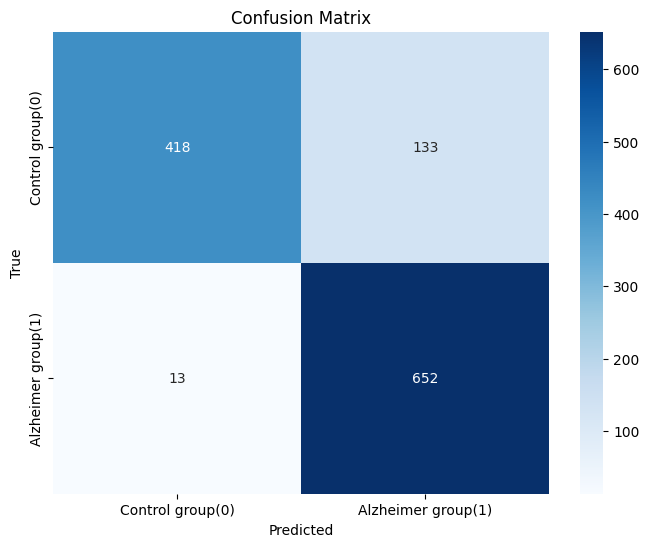

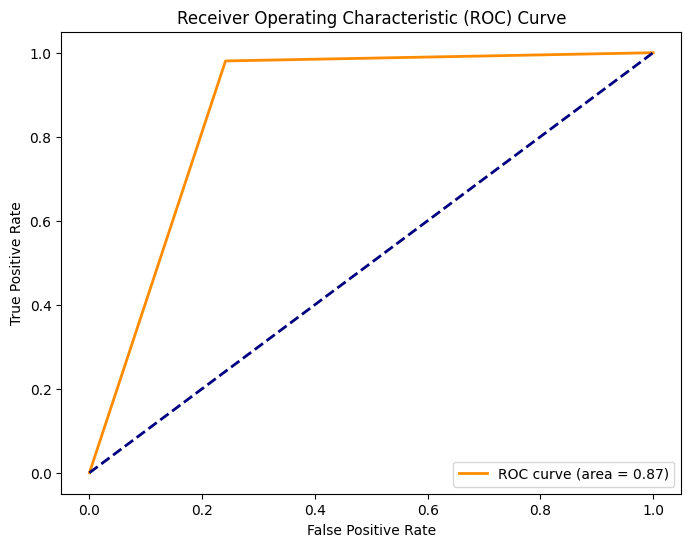

In [10]:
average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")
calculate_metrics_and_plot(confusion_true_CNN2D, confusion_pred_CNN2D)